## 1. Introdução
<p>Este <i>dataset</i> contém dados meteorológicos do Aeroporto Internacional de Raleigh Durham retirados do serviço da Web do NOAA.</p>

## 2. Lendo os Dados

In [1]:
import pandas as pd

# As colunas estão separadas pelo símbolo ';' #. 
weather_history = pd.read_csv('rdu-weather-history.csv', sep=';')

## 3. Visão geral
<p>O <i>dataset</i> contém informação sobre dados meteorológicos do Aeroporto Internacional de Raleigh Durham, desde 2007. Possui dados como temperaturas mínimas e máximas, volume de chuva, velocidade do vento e etc.</p>   
</p>Visualizando as primeiras cinco entradas do DataFrame:</p>    

In [2]:
weather_history.head()

,date,temperaturemin,temperaturemax,precipitation,snowfall,snowdepth,avgwindspeed,fastest2minwinddir,fastest2minwindspeed,fastest5secwinddir,...,drizzle,snow,freezingrain,smokehaze,thunder,highwind,hail,blowingsnow,dust,freezingfog
0,2009-10-03,55.0,82.0,0.00,0.0,0.0,2.91,240.0,16.11,230.0,...,No,No,No,No,No,No,No,No,No,No
1,2009-10-10,59.0,79.0,0.02,0.0,0.0,7.83,220.0,17.00,220.0,...,No,No,No,No,No,No,Yes,No,No,No
2,2009-10-14,46.9,61.0,0.14,0.0,0.0,8.72,40.0,14.99,50.0,...,Yes,No,No,No,No,No,Yes,No,No,No
3,2009-10-17,45.0,57.9,0.00,0.0,0.0,6.26,30.0,14.09,40.0,...,No,No,No,No,No,No,No,No,No,No
4,2009-10-29,48.0,68.0,0.00,0.0,0.0,5.82,80.0,14.99,70.0,...,No,No,No,No,No,No,No,No,No,No


In [3]:
# Número de entradas
print("Número de linhas do dataset:", weather_history.shape[0])

print("\n\nResumo estatístico do DataFrame:")
weather_history.describe()

Número de linhas do dataset: 4137


Resumo estatístico do DataFrame:


,temperaturemin,temperaturemax,precipitation,snowfall,snowdepth,avgwindspeed,fastest2minwinddir,fastest2minwindspeed,fastest5secwinddir,fastest5secwindspeed
count,4136.000000,4136.000000,4136.000000,4135.000000,4136.000000,4134.000000,4135.000000,4135.000000,4118.000000,4118.000000
mean,50.540063,72.017021,0.126630,0.012965,0.017384,5.860614,172.541717,15.957151,177.056824,21.801610
std,16.229527,16.530515,0.371318,0.195214,0.213953,2.958446,94.603272,5.270319,96.850988,7.096004
min,4.100000,23.200000,0.000000,0.000000,0.000000,0.000000,10.000000,4.920000,10.000000,6.930000
25%,37.000000,60.100000,0.000000,0.000000,0.000000,3.580000,80.000000,12.970000,90.000000,17.000000
50%,52.000000,73.900000,0.000000,0.000000,0.000000,5.370000,210.000000,14.990000,210.000000,21.030000
75%,64.900000,86.000000,0.040000,0.000000,0.000000,7.610000,240.000000,18.120000,240.000000,25.050000
max,80.100000,105.100000,6.450000,6.690000,5.910000,19.010000,360.000000,59.950000,360.000000,86.120000


In [4]:
weather_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4137 entries, 0 to 4136
Data columns (total 28 columns):
date                    4137 non-null object
temperaturemin          4136 non-null float64
temperaturemax          4136 non-null float64
precipitation           4136 non-null float64
snowfall                4135 non-null float64
snowdepth               4136 non-null float64
avgwindspeed            4134 non-null float64
fastest2minwinddir      4135 non-null float64
fastest2minwindspeed    4135 non-null float64
fastest5secwinddir      4118 non-null float64
fastest5secwindspeed    4118 non-null float64
fog                     4137 non-null object
fogheavy                4137 non-null object
mist                    4137 non-null object
rain                    4137 non-null object
fogground               4137 non-null object
ice                     4137 non-null object
glaze                   4137 non-null object
drizzle                 4137 non-null object
snow                    4137

## 3.1 Utilizando a função Seaborn de mapas de calor
<p>Seaborn é uma biblioteca em python para criação de visualizações estatísticas.</p>
<p>O método ```.corr() ```, calcula o <b>coeficiente de correlação de Pearson</b> entre todos os pares de colunas numéricas do DataFrame.</p>
<p>Interpretando o coeficiente:
- 0.9 para mais ou para menos indica uma correlação muito forte.
- 0.7 a 0.9 positivo ou negativo indica uma correlação forte.
- 0.5 a 0.7 positivo ou negativo indica uma correlação moderada.
- 0.3 a 0.5 positivo ou negativo indica uma correlação fraca.
- 0 a 0.3 positivo ou negativo indica uma correlação desprezível.

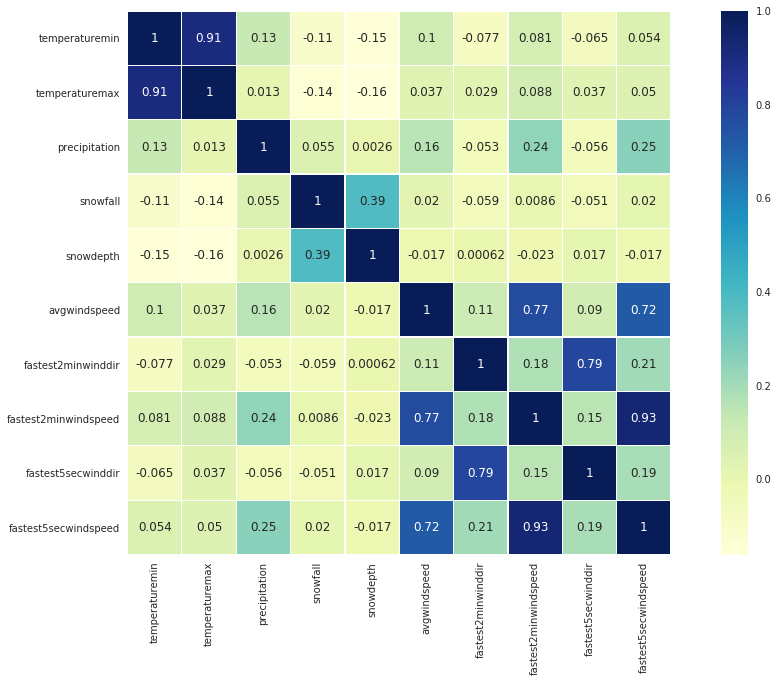

In [6]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

plt.figure(figsize=(18,10))
weather_map = sns.heatmap(weather_history.corr(), annot=True, square=True, cmap="YlGnBu", linewidths=.3)


## 4. Pré-processamento dos dados

In [7]:
# Substituindo as string por números binários -- No = 0 e Yes = 1

weather_history = weather_history.replace('No', 0.0)
weather_history = weather_history.replace('Yes', 1.0)

In [8]:
# Verificando a soma dos valores nulos em cada feature

weather_history.isnull().sum()

date                     0
temperaturemin           1
temperaturemax           1
precipitation            1
snowfall                 2
snowdepth                1
avgwindspeed             3
fastest2minwinddir       2
fastest2minwindspeed     2
fastest5secwinddir      19
fastest5secwindspeed    19
fog                      0
fogheavy                 0
mist                     0
rain                     0
fogground                0
ice                      0
glaze                    0
drizzle                  0
snow                     0
freezingrain             0
smokehaze                0
thunder                  0
highwind                 0
hail                     0
blowingsnow              0
dust                     0
freezingfog              0
dtype: int64

In [9]:
from sklearn.preprocessing import Imputer
import numpy as np

# Substituindo os valores nulos pela média dos valores referentes a feature
imputer = Imputer(missing_values=np.nan, strategy='median', axis=0)
weather_history[['temperaturemin']] = imputer.fit_transform(weather_history[['temperaturemin']])
weather_history[['temperaturemax']] = imputer.fit_transform(weather_history[['temperaturemax']])
weather_history[['precipitation']] = imputer.fit_transform(weather_history[['precipitation']])
weather_history[['snowfall']] = imputer.fit_transform(weather_history[['snowfall']])
weather_history[['snowdepth']] = imputer.fit_transform(weather_history[['snowdepth']])
weather_history[['avgwindspeed']] = imputer.fit_transform(weather_history[['avgwindspeed']])
weather_history[['fastest2minwinddir']] = imputer.fit_transform(weather_history[['fastest2minwinddir']])
weather_history[['fastest2minwindspeed']] = imputer.fit_transform(weather_history[['fastest2minwindspeed']])
weather_history[['fastest5secwinddir']] = imputer.fit_transform(weather_history[['fastest5secwinddir']])
weather_history[['fastest5secwindspeed']] = imputer.fit_transform(weather_history[['fastest5secwindspeed']])

weather_history.isnull().sum()

date                    0
temperaturemin          0
temperaturemax          0
precipitation           0
snowfall                0
snowdepth               0
avgwindspeed            0
fastest2minwinddir      0
fastest2minwindspeed    0
fastest5secwinddir      0
fastest5secwindspeed    0
fog                     0
fogheavy                0
mist                    0
rain                    0
fogground               0
ice                     0
glaze                   0
drizzle                 0
snow                    0
freezingrain            0
smokehaze               0
thunder                 0
highwind                0
hail                    0
blowingsnow             0
dust                    0
freezingfog             0
dtype: int64

## 4.1 Agrupamento dos dados para teste

<p>Como o clima de uma região possui uma grande relação com as estações do ano, os dados para teste foram agrupados de acordo com a estação que occorre em uma data específica.</p>

- Primavera: 20 de março a 20 de junho 
- Verão: 21 de junho a 21 de setembro
- Outono: 22 de setembro a 20 de dezembro
- Inverno: 21 de dezembro a 19 de março

### 4.1.1 Criando nova coluna "Season"

<p>A coluna "season" foi criada com base nos periodos de inicio e de fim das estações do ano no local em que os dados foram colhidos.</p>
<p>Antes de utilizar o algoritimo para definir as estações a partir das datas é feita uma pequena alteração no formato da data.</p>   

Antes: <b>AAAA-MM-DD</b>  
Depois: <b>AAAAMMDD</b>

In [10]:
weather_history['date'] = weather_history['date'].replace({'-':''}, regex=True)

In [11]:
season_array = np.zeros(4137)
meantemp_array = np.zeros(4137)

for i in range(0, 4137):
    #formato: MMDD
    monthDay = int(weather_history['date'][i][4:8])
    
    if monthDay >= 1201 or monthDay < 301:
        season = 0 #'winter'
    elif monthDay >= 301 and monthDay < 601:
        season = 1 #'spring'
    elif monthDay >= 601 and monthDay < 901:
        season = 2 #'summer'
    elif monthDay >= 901 and monthDay < 1201:
        season = 3 #'autumn'    
    
    season_array[i] = season

weather_history['season'] = season_array

### 4.1.2 Criando DataFrames separados para cada estação    


In [12]:
winter_weather_history = weather_history[weather_history['season'] == 0]
summer_weather_history = weather_history[weather_history['season'] == 1]
spring_weather_history = weather_history[weather_history['season'] == 2]
autumn_weather_history = weather_history[weather_history['season'] == 3]

print("\nNúmero de linhas do dataframe:", winter_weather_history.shape[0])
print("\nNúmero de linhas do dataframe:", summer_weather_history.shape[0])
print("\nNúmero de linhas do dataframe:", spring_weather_history.shape[0])
print("\nNúmero de linhas do dataframe:", autumn_weather_history.shape[0])
#spring_weather_history.head()
#print(autumn_weather_history.head())


Número de linhas do dataframe: 1052

Número de linhas do dataframe: 1072

Número de linhas do dataframe: 1012

Número de linhas do dataframe: 1001


## 5. Lasso (Least Absolute Shrinkage Selector Operator)    

<p>O Lasso seleciona apenas algumas 'features', enquanto reduz os coeficientes de outras para zero. Essa propriedade é conhecida como 'feature selection' e está ausente no Ridge.</p>

## 5.1.1 Lasso - Winter Weather Dataset


Coeficientes:
 [ 0.          0.56684968  0.82019677 -0.         -0.          0.02182923
 -0.          0.         -0.          0.          3.07176857  0.
  0.          0.         -0.          0.          0.          0.
  0.          0.         -0.          0.          0.          0.
  0.          0.          0.          0.        ]

Score: 0.6500763693859573

[21.92905508 32.06882631 40.53682307 27.91098245 38.10167112 29.89900424
 40.73565634 27.53402885 30.46883898 20.80015815 32.77790431 28.47997025
 31.77826365 39.08889635 33.45765648 27.07457898 41.92619799 25.87804125
 46.01333624 30.014499   32.11965421 37.51240836 28.89062278 32.69919905
 40.54068251 29.19251851 48.18796074 28.67253065 33.054728   27.60715677
 38.38413884 40.63671071 39.09871951 30.44439025 30.91548064 31.7785711
 29.18771608 34.60301385 38.2376647  34.25028891 28.01974483 35.72207015
 37.35130864 23.94109916 29.98535485 51.20312983 37.97484329 27.59755191
 34.95175391 34.44104565 27.64623109 37.36593423 26.932

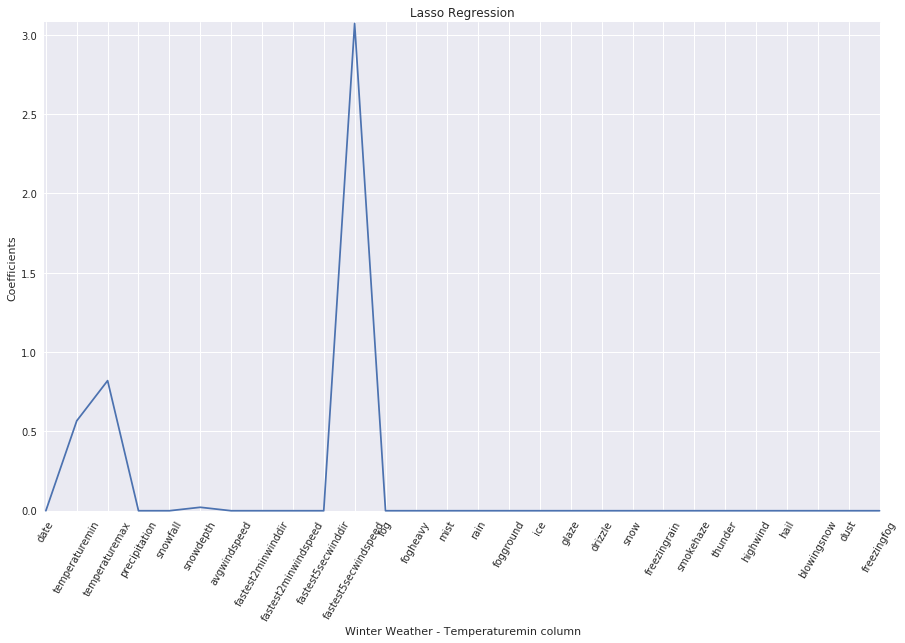

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

X_winter = winter_weather_history.drop('temperaturemin', axis=1)
X_winter.shape

y_winter = (winter_weather_history['temperaturemin'])
y_winter.shape

X_train, X_test, y_train, y_test = train_test_split(X_winter, y_winter, test_size = 0.3, random_state=42)

lasso = Lasso(alpha=0.05, normalize=True)
lasso.fit(X_train, y_train) 

lasso_coef = lasso.coef_
print("\nCoeficientes:\n", lasso_coef)
print("\nScore:",lasso.score(X_train, y_train))
print()
predict = lasso.predict(X_test)
print(predict)


plt.figure(figsize=(15,9))
plt.plot(lasso_coef)
plt.xticks(range(len(winter_weather_history.columns)), winter_weather_history.columns.values, rotation=60)
plt.margins(0.002)

plt.xlabel('Winter Weather - Temperaturemin column')
plt.ylabel('Coefficients')
plt.title('Lasso Regression')
plt.show()


## 5.1.2 Lasso - Summer Weather Dataset


Coeficientes:
 [ 0.          0.66797546  0.87755999 -0.         -0.          0.
 -0.         -0.         -0.         -0.          1.25947024  0.
  0.          0.65223544 -0.         -0.          0.          0.
 -0.          0.          0.          0.          0.          0.
 -0.          0.          0.          0.        ]

Score: 0.652863006932184

[50.60363866 30.3781498  41.2519822  41.98675521 38.58008035 51.20481658
 44.59185951 24.55259565 55.61440953 35.97497605 51.93958959 39.18125827
 60.62327059 60.07724599 54.01031352 47.99853436 49.14470311 55.88064481
 45.92781043 52.61815183 52.09399322 49.91992318 45.19303742 55.26372687
 55.26978376 58.50239278 49.86886566 51.93958959 50.61388411 50.77468596
 46.60637267 49.26768774 45.85132975 59.33837719 51.93958959 51.93958959
 51.86310891 31.23235027 49.26768774 45.19303742 59.94561199 57.87488806
 41.91027452 43.24622545 50.60363866 42.58793312 59.94561199 59.21083899
 50.34902004 49.2580046  39.78049877 60.01581679 49.2667802  38

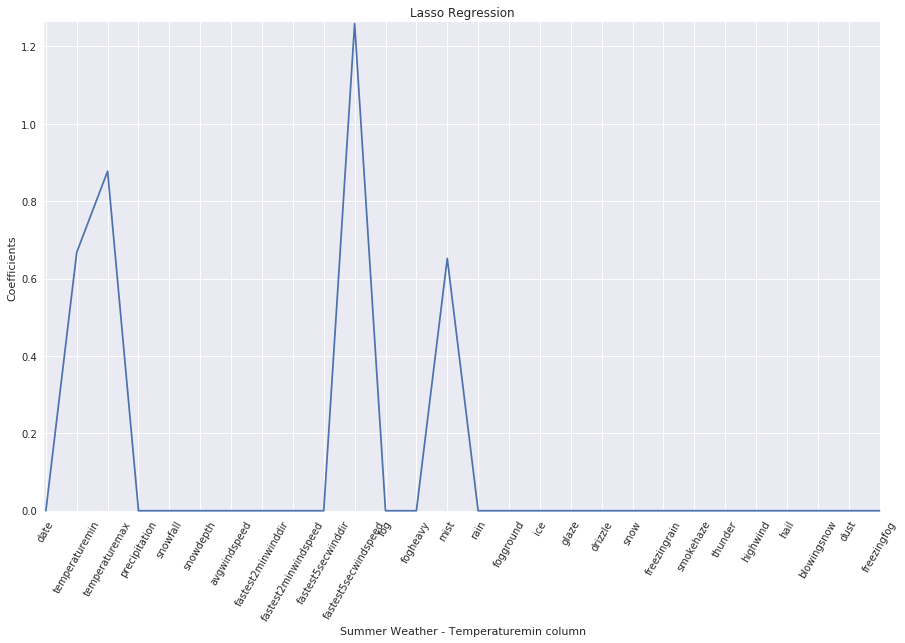

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

X_summer = summer_weather_history.drop('temperaturemin', axis=1)
X_summer.shape

y_summer = (summer_weather_history['temperaturemin'])
y_summer.shape

X_train, X_test, y_train, y_test = train_test_split(X_summer, y_summer, test_size = 0.3, random_state=42)

lasso = Lasso(alpha=0.05, normalize=True)
lasso.fit(X_train, y_train) 

lasso_coef = lasso.coef_
print("\nCoeficientes:\n", lasso_coef)
print("\nScore:",lasso.score(X_train, y_train))
print()
predict = lasso.predict(X_test)
print(predict)


plt.figure(figsize=(15,9))
plt.plot(lasso_coef)
plt.xticks(range(len(summer_weather_history.columns)), summer_weather_history.columns.values, rotation=60)
plt.margins(0.002)

plt.xlabel('Summer Weather - Temperaturemin column')
plt.ylabel('Coefficients')
plt.title('Lasso Regression')
plt.show()


## 5.1.3 Lasso - Spring Weather Dataset


Coeficientes:
 [ 0.          0.36393523  0.00587513  0.          0.          0.25290027
  0.          0.          0.          0.          0.33177585  0.
  0.          0.         -0.          0.          0.          0.
  0.          0.          0.          0.21938158 -0.          0.
 -0.          0.          0.          0.        ]

Score: 0.3647300132565191

[67.78942036 66.55786061 66.79348143 72.4719076  64.63137747 70.56102237
 69.32755885 64.90045836 68.35219741 72.59701337 65.71796635 71.69735797
 69.99938681 67.4108221  65.99609925 69.28303725 69.37257607 68.42194087
 73.96645029 70.62625275 70.40551989 70.4562341  66.27127822 69.94835231
 72.32185219 61.23905618 63.22783506 66.88641988 69.13942549 71.35120175
 68.42480813 68.54945021 67.57315477 69.99227629 68.13869257 69.94217856
 72.61644516 72.47048065 69.19596174 69.20182482 72.88598925 70.67489454
 68.85505904 69.72748316 74.30307166 66.89921722 70.95329733 66.5021638
 67.45072716 69.22722294 70.39260505 71.07261115 74.056

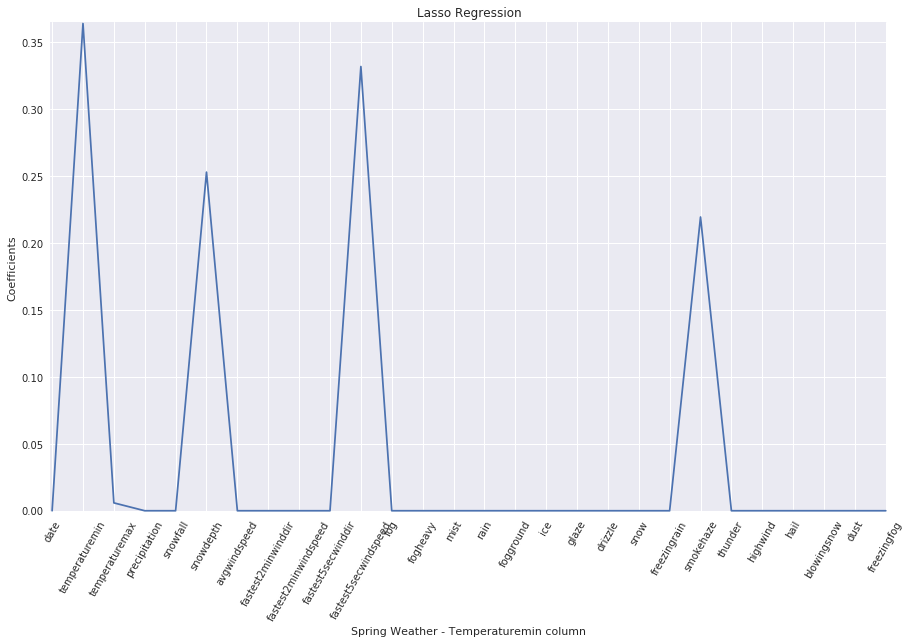

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

X_spring = spring_weather_history.drop('temperaturemin', axis=1)
X_spring.shape

y_spring = (spring_weather_history['temperaturemin'])
y_spring.shape

X_train, X_test, y_train, y_test = train_test_split(X_spring, y_spring, test_size = 0.3, random_state=42)

lasso = Lasso(alpha=0.02, normalize=True)
lasso.fit(X_train, y_train) 

lasso_coef = lasso.coef_
print("\nCoeficientes:\n", lasso_coef)
print("\nScore:",lasso.score(X_train, y_train))
print()
predict = lasso.predict(X_test)
print(predict)


plt.figure(figsize=(15,9))
plt.plot(lasso_coef)
plt.xticks(range(len(spring_weather_history.columns)), spring_weather_history.columns.values, rotation=60)
plt.margins(0.002)

plt.xlabel('Spring Weather - Temperaturemin column')
plt.ylabel('Coefficients')
plt.title('Lasso Regression')
plt.show()

## 5.1.4 Lasso - Autumn Weather Dataset


Coeficientes:
 [ 0.00000000e+00  7.98976043e-01  7.65028444e-01 -0.00000000e+00
  0.00000000e+00  7.03167407e-01 -6.58032640e-03 -0.00000000e+00
 -1.41607365e-03  0.00000000e+00  1.63298092e+00  0.00000000e+00
  0.00000000e+00  1.08615513e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]

Score: 0.7533038220756545

[49.48240241 44.36144381 59.10492888 54.93502494 51.29501673 61.67678719
 44.8077876  67.91250701 41.32769597 54.60263704 53.87109928 60.21561218
 57.7315794  53.26042577 62.2569519  43.96848515 65.38453576 57.83425282
 68.84915581 63.846228   44.43565216 50.41854115 44.15400112 59.14498432
 57.07625117 52.39645606 54.23255887 40.28479161 58.30659935 58.30687737
 65.76363852 48.81218941 53.11426409 50.15534846 60.06152266 55.39225277
 35.52912908 59.64655547 63.5448674  60.85749955 44.3850109  6

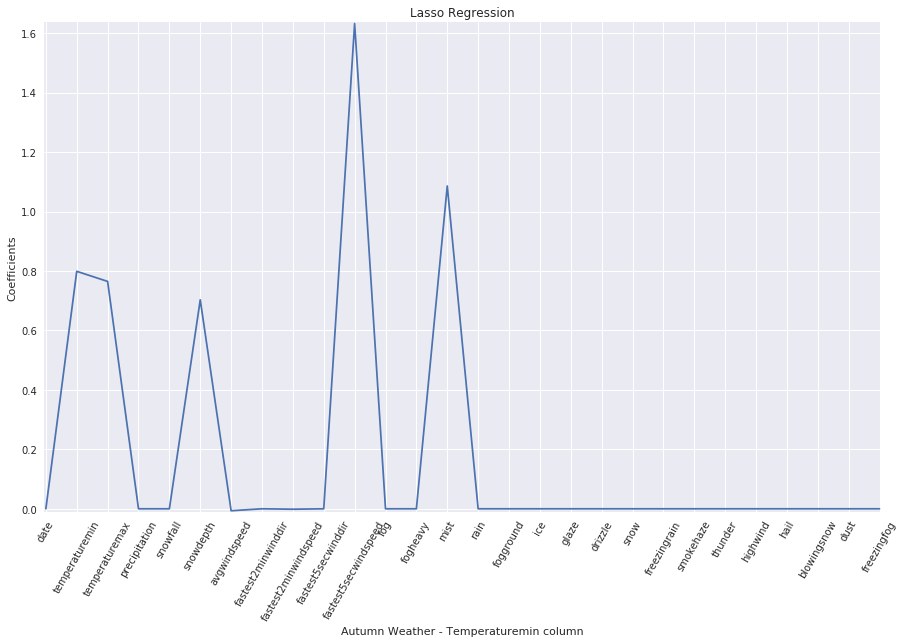

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

X_autumn = autumn_weather_history.drop('temperaturemin', axis=1)
X_autumn.shape

y_autumn = (autumn_weather_history['temperaturemin'])
y_autumn.shape

X_train, X_test, y_train, y_test = train_test_split(X_autumn, y_autumn, test_size = 0.3, random_state=42)

lasso = Lasso(alpha=0.04, normalize=True)
lasso.fit(X_train, y_train) 

lasso_coef = lasso.coef_
print("\nCoeficientes:\n", lasso_coef)
print("\nScore:",lasso.score(X_train, y_train))
print()
predict = lasso.predict(X_test)
print(predict)


plt.figure(figsize=(15,9))
plt.plot(lasso_coef)
plt.xticks(range(len(autumn_weather_history.columns)), autumn_weather_history.columns.values, rotation=60)
plt.margins(0.002)

plt.xlabel('Autumn Weather - Temperaturemin column')
plt.ylabel('Coefficients')
plt.title('Lasso Regression')
plt.show()

## 6. Referências   

> [Coeficiente de correlação de Pearson](https://pt.wikipedia.org/wiki/Coeficiente_de_correla%C3%A7%C3%A3o_de_Pearson#Refer%C3%AAncias)

> [A comprehensive beginners guide for Linear, Ridge and Lasso Regression](https://www.analyticsvidhya.com/blog/2017/06/a-comprehensive-guide-for-linear-ridge-and-lasso-regression/)



